In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


/home/federico/anaconda3/envs/bioenv/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/federico/anaconda3/envs/bioenv/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Introduction to VAEs
Variational Autoencoders are, in practice, the most common form of Black Box Variational Inference (BBVI). Here we will only look at them from a practical point of view. In particular, we will stress the differences with normal autoencoders, mainly used for dimensionality reduction.

## Normal Autoencoders

In [2]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Output: 16 x 14 x 14
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Output: 32 x 7 x 7
            nn.ReLU(True),
            nn.Flatten(),  # Flatten for the linear layers
            nn.Linear(32 * 7 * 7, 10)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 32 * 7 * 7),
            nn.Unflatten(1, (32, 7, 7)),  # Unflatten to 32 x 7 x 7
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # Output: 16 x 14 x 14
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # Output: 1 x 28 x 28
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z
    

# Display some original and reconstructed images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [49]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = torch.utils.data.Subset(train_dataset, range(10000))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = torch.utils.data.Subset(test_dataset, range(1000))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the network and the optimizer
AE = ConvAutoencoder()
optimizer = torch.optim.SGD(AE.parameters(), lr=0.00001, momentum=0.9)
criterion = nn.MSELoss(reduction='sum')

In [50]:
# Train the Autoencoder
n_epochs = 5
for epoch in range(n_epochs):
    for data in train_loader:
        img, _ = data
        #img = img.view(img.size(0), -1)
        #if convolutional
        img = img.view(img.size(0), 1, 28, 28)
        # Forward pass
        output, _ = AE(img)
        loss = criterion(output, img)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluation phase
    AE.eval()  # Set the network to evaluation mode

    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for img,_ in train_loader:
            #img = img.view(img.size(0), -1)
            #if convolutional
            img = img.view(img.size(0), 1, 28, 28)
            train_output,_ = AE(img)
            train_loss += criterion(train_output, img).item()           
    train_loss /= len(train_loader)

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for img,_ in test_loader:
            #img = img.view(img.size(0), -1)
            #if convolutional
            img = img.view(img.size(0), 1, 28, 28)
            test_output,_ = AE(img)
            test_loss += criterion(test_output, img).item()
    test_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')

Epoch 1/5 - Train Loss: 7348.174634411077, Test Loss: 7143.400360107422
Epoch 2/5 - Train Loss: 6242.264893355643, Test Loss: 6223.5902099609375
Epoch 3/5 - Train Loss: 5781.5626329555635, Test Loss: 5793.868560791016
Epoch 4/5 - Train Loss: 5431.86622959793, Test Loss: 5446.9532470703125
Epoch 5/5 - Train Loss: 5281.941911636644, Test Loss: 5307.659194946289


In [57]:
AE.eval()
with torch.no_grad():
    # Get a batch of data
    images, labels = next(iter(train_loader_2))
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    #images = images.view(images.size(0), -1)
    # Forward pass through the encoder
    _, representations = AE(images)


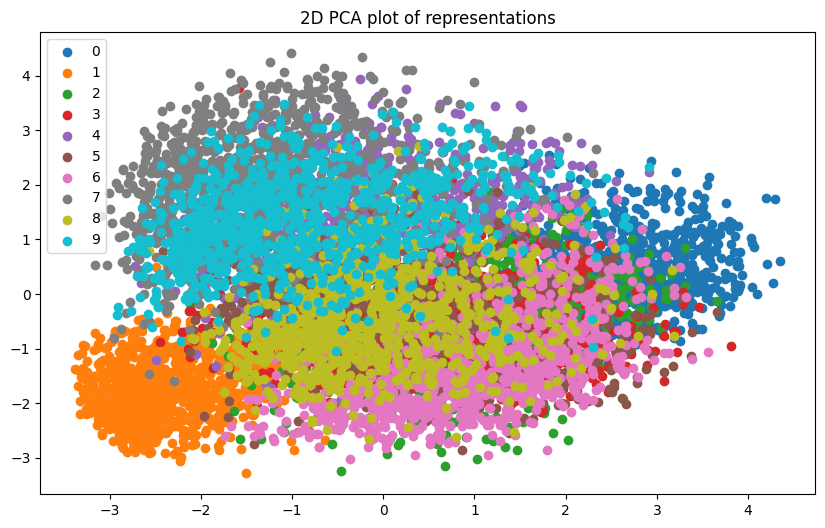

In [58]:
#do PCA instead
pca = PCA(n_components=2)
representations_2d = pca.fit_transform(representations)
# Plot the resulting points
plt.figure(figsize=(10, 6))
for i in range(10):
    indices = labels == i
    plt.scatter(representations_2d[indices, 0], representations_2d[indices, 1], label=str(i), alpha=1)
plt.legend()
plt.title('2D PCA plot of representations')
plt.show()

In [59]:
# Number of images to display
num_images = 6

# Get a batch of test images
images, _ = next(iter(test_loader))
original_images = images  # Save the original images for comparison


AE.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    #images = images.view(images.size(0), -1)
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, latent = AE(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format
    print(latent.shape)


torch.Size([64, 10])


Original Images


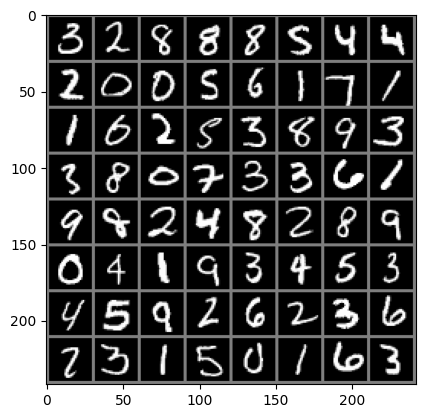

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


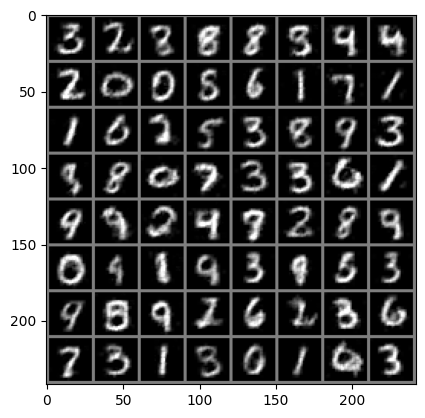

In [60]:


# Display original images
print("Original Images")
imshow(torchvision.utils.make_grid(original_images))
plt.show()

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


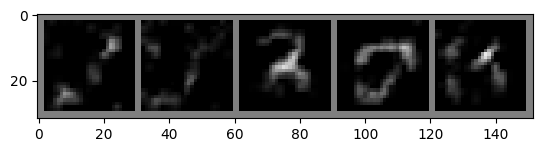

In [61]:
#how to "sample" from the latent space?
#generate random numbers from a normal distribution
#feed them through the decoder

latent_space_samples = torch.randn(5, 10)
output = AE.decoder(latent_space_samples)
output = output.view(-1, 1, 28, 28)

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(output))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4, 9, 1, 6, 4, 7, 3, 4, 6, 4])


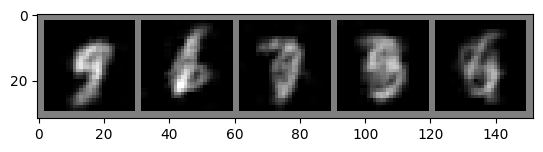

In [63]:
#feed 10 images in the encoder and get the latent representations
# Get a batch of test images
images, labels = next(iter(test_loader))
original_images = images  # Save the original images for comparison

print(labels[:10])
AE.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, latent = AE(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format
    reconstructed = reconstructed[:10]

pair_means = []
for i in range(0, len(reconstructed), 2):  # Step by 2
    if i+1 < len(reconstructed):  # Check if there is a pair
        mean_img = 0.5 * (reconstructed[i] + reconstructed[i+1])  # Calculate the mean
        pair_means.append(mean_img)

imshow(torchvision.utils.make_grid(pair_means))

## Ok, now let's try to do the same with a VAE!

In [11]:
#this needs two big modifications: one in the actual model, and one in the loss function

class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten()
        )
        self.get_mu = nn.Linear(32 * 7 * 7, 10)
        self.get_logvar = nn.Linear(32 * 7 * 7, 10)

        # Decoder
        self.decoder_fc = nn.Linear(10, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.get_mu(encoded)
        logvar = self.get_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        return self.decoder(self.decoder_fc(z)), mu, logvar
    

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [26]:
VAE = ConvVAE()
optimizer = torch.optim.SGD(VAE.parameters(), lr=0.00001, weight_decay=1e-5, momentum=0.9)
criterion = nn.MSELoss(reduction='sum')

In [34]:
n_epochs = 5

# Calculate training loss over the entire training set
train_loss = 0
with torch.no_grad():  # No need to track gradients
    for img,_ in train_loader:
        #img = img.view(img.size(0), -1)
        #if convolutional
        img = img.view(img.size(0), 1, 28, 28)
        train_output, mu, logvar = VAE(img)
        train_loss += ((criterion(train_output, img)+kl_divergence(mu,logvar)).item()/img.size(0))           
train_loss /= len(train_loader)
print(f'Initial Train Loss: {train_loss}')

for epoch in range(n_epochs):
    for data in train_loader:
        img, _ = data
        #img = img.view(img.size(0), -1)
        #if convolutional
        img = img.view(img.size(0), 1, 28, 28)
        # Forward pass
        output, mu, logvar = VAE(img)
        loss = criterion(output, img)+kl_divergence(mu, logvar)
        #loss = criterion(output, img)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluation phase
    VAE.eval()  # Set the network to evaluation mode

    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for img,_ in train_loader:
            #img = img.view(img.size(0), -1)
            #if convolutional
            img = img.view(img.size(0), 1, 28, 28)
            train_output, mu, logvar = VAE(img)
            train_loss += ((criterion(train_output, img)+kl_divergence(mu,logvar)).item()/img.size(0))           
    train_loss /= len(train_loader)

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for img,_ in test_loader:
            #img = img.view(img.size(0), -1)
            #if convolutional
            img = img.view(img.size(0), 1, 28, 28)
            test_output, mu, logvar = VAE(img)
            test_loss += ((criterion(test_output, img)+kl_divergence(mu,logvar)).item()/img.size(0))
    test_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')

Initial Train Loss: 111.80145341423666
Epoch 1/5 - Train Loss: 106.58494504697764, Test Loss: 107.62938041687012
Epoch 2/5 - Train Loss: 111.27766039417048, Test Loss: 111.43567333221435
Epoch 3/5 - Train Loss: 102.13330039249104, Test Loss: 103.27295036315918
Epoch 4/5 - Train Loss: 103.93660687489115, Test Loss: 105.99641189575195
Epoch 5/5 - Train Loss: 100.15355925347394, Test Loss: 101.98666276931763


In [35]:
# Get a batch of test images
images, _ = next(iter(test_loader))
original_images = images  # Save the original images for comparison


VAE.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    #images = images.view(images.size(0), -1)
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, mu, logvar = VAE(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format
    print(latent.shape)

torch.Size([64, 10])


Original Images


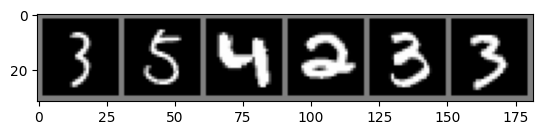

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


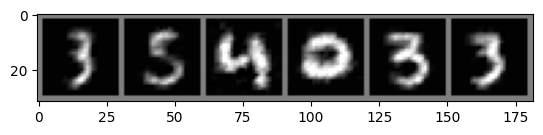

In [36]:
# Number of images to display
num_images = 6

# Display original images
print("Original Images")
imshow(torchvision.utils.make_grid(original_images[:num_images]))
plt.show()

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed[:num_images]))
plt.show()

In [42]:
VAE.eval()
with torch.no_grad():
    # Get a batch of data
    images, labels = next(iter(train_loader_2))
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    #images = images.view(images.size(0), -1)
    # Forward pass through the encoder
    _, representations, _ = VAE(images)

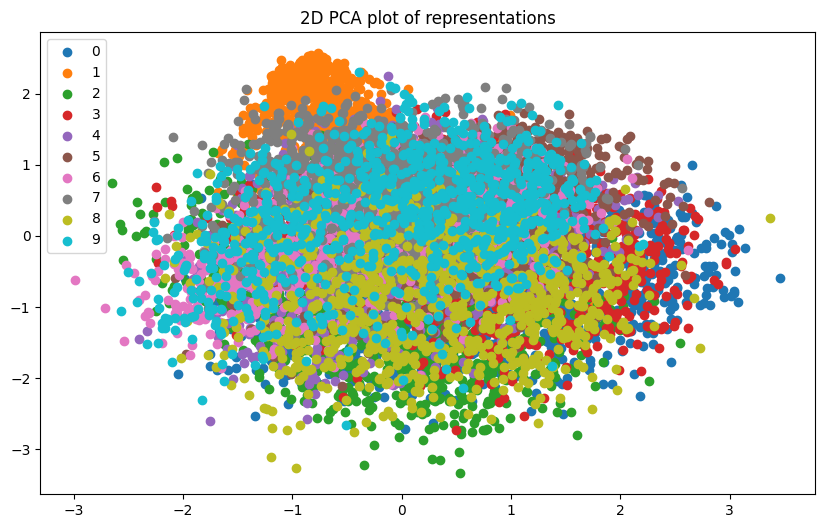

In [43]:
#do PCA instead
pca = PCA(n_components=2)
representations_2d = pca.fit_transform(representations)
representations_2d = representations[:, :2].numpy()
# Plot the resulting points
plt.figure(figsize=(10, 6))
for i in range(10):
    indices = labels == i
    plt.scatter(representations_2d[indices, 0], representations_2d[indices, 1], label=str(i), alpha=1)
plt.legend()
plt.title('2D PCA plot of representations')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


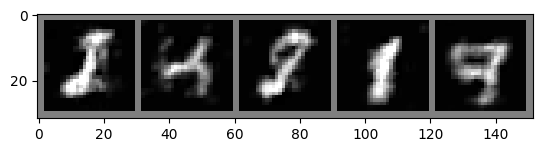

In [39]:
#generate random numbers from a normal distribution
#feed them through the decoder

latent_space_samples = torch.randn(5, 10)
output = VAE.decoder(VAE.decoder_fc(latent_space_samples))
output = output.view(-1, 1, 28, 28)

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(output))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 1, 28, 28])


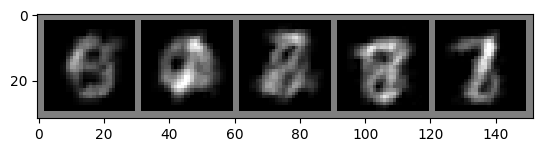

In [40]:
#feed 10 images in the encoder and get the latent representations
# Get a batch of test images
images, _ = next(iter(test_loader))
original_images = images  # Save the original images for comparison

AE.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, latent = AE(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format
    reconstructed = reconstructed[:10]
    print(reconstructed.shape)

pair_means = []
for i in range(0, len(reconstructed), 2):  # Step by 2
    if i+1 < len(reconstructed):  # Check if there is a pair
        mean_img = 0.5 * (reconstructed[i] + reconstructed[i+1])  # Calculate the mean
        pair_means.append(mean_img)

imshow(torchvision.utils.make_grid(pair_means))